In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Part 1: Data preparation and model development

## 1. Download data

In [ ]:
# Descargar precios de los 5 años anteriores
data = yf.download('ETH-USD', period='5y')
data.columns = data.columns.droplevel(1)

data = data[['Close']]

/tmp/ipython-input-2-3855611336.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download('ETH-USD', period='5y')
[*********************100%***********************]  1 of 1 completed


<Axes: xlabel='Date'>

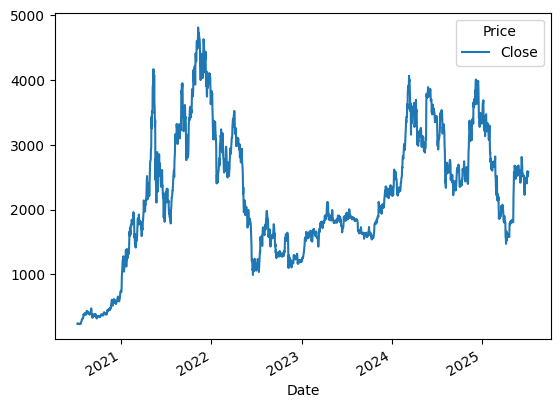

In [ ]:
data.plot()

## 2. Normalize Data

In [ ]:
# Preprocesamiento
sclaer = MinMaxScaler(feature_range=(0,1))
scaled_data = sclaer.fit_transform(data)

## 3. Create sequences

In [ ]:
# Crear las secuencias para el modelo LSTM
def create_dataset(data, time_steps=20):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i-time_steps:i, 0])
        y.append(data[i, 0]) #Precio futuro (día siguiente)
    return np.array(X), np.array(y)

X, y = create_dataset(scaled_data)

In [ ]:
# Redimensionar X para que sea compatible con LSTM
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

## 4. Split data

In [ ]:
# Dividir los datos en Train y Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)

## 5. Build the LSTM Model

In [ ]:
# Construir el modelo LSTM
model = Sequential()

# Crear capa de entrada
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
# Crear capas ocultas
model.add(LSTM(units=60, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))

# Crear capa de salida (Densa)
model.add(Dense(units=1))



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## 6. Compile and Summarize the model

In [ ]:
# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Resumen del modelo
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 20, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 20, 60)         │        26,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20, 60)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        22,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,291 (231.61 KB)

 Trainable params: 59,291 (231.61 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Entrenar el modelo
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - loss: 0.0510 - mae: 0.1618 - val_loss: 0.0037 - val_mae: 0.0484
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0055 - mae: 0.0526 - val_loss: 0.0062 - val_mae: 0.0614
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0050 - mae: 0.0500 - val_loss: 0.0035 - val_mae: 0.0438
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0050 - mae: 0.0489 - val_loss: 0.0033 - val_mae: 0.0423
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0045 - mae: 0.0473 - val_loss: 0.0057 - val_mae: 0.0632
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0051 - mae: 0.0495 - val_loss: 0.0027 - val_mae: 0.0387
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0036 - mae: 0.0413 - val_loss: 0.0026 - val_mae: 0.0379
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0042 - mae: 0.0449 - val_loss: 0.0023 - val_mae: 0.0356
Epoch 9/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.003

## 7. Train and predict

In [ ]:
# Predicción de precios con el modelo LSTM
y_pred = model.predict(X_test)
# Desnormalizar las predicciones a la escala orginal de precios
y_pred = y_pred.reshape(-1, 1) # Reshape to 2 dimensions
y_pred = sclaer.inverse_transform(y_pred).flatten() # Flatten to 1 dimension

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step


In [ ]:
y_test = sclaer.inverse_transform(y_test.reshape(-1, 1)).flatten()

In [ ]:
y_test

array([2524.46020508, 2576.59790039, 2472.24121094, 2511.36376953,
       2587.69116211, 2528.36938477, 2467.01879883, 2489.49853516,
       2469.58911133, 2453.91308594, 2310.82641602, 2240.68603516,
       2233.56176758, 2217.71020508, 2267.19970703, 2267.88598633,
       2257.20874023, 2317.06420898, 2344.49365234, 2282.54443359,
       2303.82470703, 2308.03808594, 2296.03833008, 2289.54614258,
       2298.88891602, 2372.2019043 , 2423.74511719, 2419.90649414,
       2487.515625  , 2501.22827148, 2507.57055664, 2658.1159668 ,
       2642.18530273, 2777.90234375, 2824.37890625, 2803.69140625,
       2786.67260742, 2878.99804688, 2943.57470703, 3013.50366211,
       2970.35546875, 2971.00732422, 2921.65820312, 2992.38598633,
       3112.69726562, 3178.99365234, 3244.51928711, 3385.70385742,
       3341.91967773, 3435.05395508, 3422.04980469, 3490.99365234,
       3630.43383789, 3554.96459961, 3819.22631836, 3874.34765625,
       3892.06103516, 3915.41894531, 3881.19311523, 4066.44506

In [ ]:
# Mostrar algunos valores predichos y reales
print("Predicciones vs Precios Reales")
for i in range(100):
    print(f"Predicción {i+1}: {y_pred[i]}, Precio Real: {y_test[i]}")

Predicciones vs Precios Reales
Predicción 1: 2240.26171875, Precio Real: 2524.460205078125
Predicción 2: 2272.139892578125, Precio Real: 2576.597900390625
Predicción 3: 2308.083251953125, Precio Real: 2472.2412109375
Predicción 4: 2341.15869140625, Precio Real: 2511.36376953125
Predicción 5: 2369.218994140625, Precio Real: 2587.691162109375
Predicción 6: 2394.87109375, Precio Real: 2528.369384765625
Predicción 7: 2415.324951171875, Precio Real: 2467.018798828125
Predicción 8: 2428.05859375, Precio Real: 2489.49853515625
Predicción 9: 2434.232666015625, Precio Real: 2469.5891113281255
Predicción 10: 2434.521240234375, Precio Real: 2453.9130859375
Predicción 11: 2430.205078125, Precio Real: 2310.826416015625
Predicción 12: 2417.45458984375, Precio Real: 2240.68603515625
Predicción 13: 2394.26318359375, Precio Real: 2233.5617675781245
Predicción 14: 2363.760986328125, Precio Real: 2217.710205078125
Predicción 15: 2328.507080078125, Precio Real: 2267.19970703125
Predicción 16: 2293.4384765

## 8. Backtesting

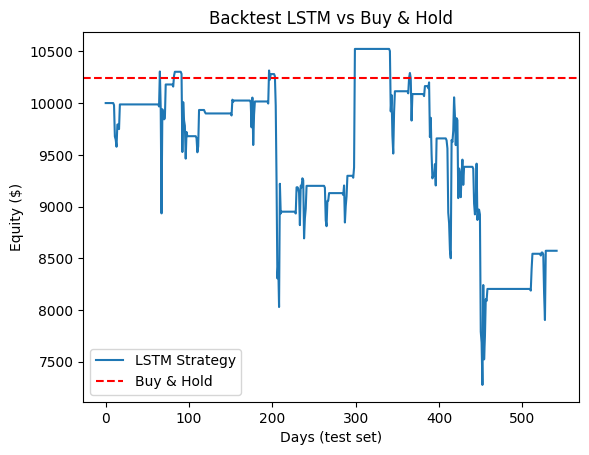

Final equity LSTM strategy: $8572.14
Buy & Hold equity: $10238.23
Return LSTM strategy: -14.28%
Return Buy & Hold: 2.38%


In [ ]:
# 6. Backtesting: estrategia simple
# Si predicción de mañana > precio de hoy, compro; si es menor, vendo
initial_cash = 10000
cash = initial_cash
asset = 0
equity_curve = []

comission = 0.002
for i in range(len(y_test)-1):
    price_today = y_test[i]
    price_pred = y_pred[i]
    # Buy
    if price_pred > price_today and cash > 0:
        asset = (cash * (1-comission)) / price_today
        cash = 0
    # Sell
    elif price_pred < price_today and asset > 0:
        cash = (asset * price_today)*(1-comission)
        asset = 0
    # Track equity
    total_equity = cash + asset * price_today
    equity_curve.append(total_equity)

# Cierre de posición al final
if asset > 0:
    cash = asset * y_test[-1]*(1-comission)
    asset = 0
equity_curve.append(cash)

# Buy & Hold
price_initial = y_test[0]
price_final = y_test[-1]
buy_hold = initial_cash * (price_final / price_initial)

# 7. Resultados
plt.plot(equity_curve, label="LSTM Strategy")
plt.axhline(buy_hold, color='r', linestyle='--', label="Buy & Hold")
plt.title("Backtest LSTM vs Buy & Hold")
plt.xlabel("Days (test set)")
plt.ylabel("Equity ($)")
plt.legend()
plt.show()

# USD
print(f"Final equity LSTM strategy: ${equity_curve[-1]:.2f}")
print(f"Buy & Hold equity: ${buy_hold:.2f}")

# Percentage
print(f"Return LSTM strategy: {((equity_curve[-1] - initial_cash) / initial_cash) * 100:.2f}%")
print(f"Return Buy & Hold: {((buy_hold - initial_cash) / initial_cash) * 100:.2f}%")

## 9. Save models and Scaler

In [ ]:
model.save('model.keras')

In [ ]:
# Guardar el scaler para uso futuro
import joblib
joblib.dump(sclaer, 'scaler.pkl')

['scaler.pkl']

# Part 2: Model Utilization and Extension
## 10. Class implementation

In [ ]:
# Clase LSTMPricePredictor
from keras.models import load_model
import joblib
class LSTMPricePredictor:
    def __init__(self,
                 model_path: str = 'model.keras',
                 scaler_path: str = 'scaler.pkl',
                 time_steps: int = 20):
        self.model = load_model(model_path)
        self.scaler = joblib.load(scaler_path)
        self.time_steps = time_steps


## 10.1 Predict next price

In [ ]:
#Predict next price
class LSTMPricePredictor(LSTMPricePredictor):
    def predict_next(self, recent_prices: np.ndarray) -> float:
        if len(recent_prices) != self.time_steps:
            raise ValueError(f"Tienes que pasar exactamente {self.time_steps} precios.")

        scaled = self.scaler.transform(recent_prices.reshape(-1, 1))
        X = scaled.reshape(1, self.time_steps, 1)
        y_scaled = self.model.predict(X)
        y_real = self.scaler.inverse_transform(y_scaled)[0, 0]
        return float(y_real)


## 10.2 Retrain model

In [ ]:
# Retrain model (fine-tuning)
class LSTMPricePredictor(LSTMPricePredictor):
    def retrain_model(self,
                      full_price_series: np.ndarray,
                      epochs: int = 5,
                      batch_size: int = 32,
                      test_size: float = 0.2,
                      shuffle: bool = False):

        # 1) Escalar toda la serie
        scaled_all = self.scaler.transform(full_price_series.reshape(-1, 1))

        # 2) Generar X_all, y_all
        X_all, y_all = [], []
        for i in range(self.time_steps, len(scaled_all)):
            X_all.append(scaled_all[i-self.time_steps:i, 0])
            y_all.append(scaled_all[i, 0])
        X_all = np.array(X_all).reshape(-1, self.time_steps, 1)
        y_all = np.array(y_all)

        # 3) Dividir datos (train/val) sin shuffle
        X_tr, X_val, y_tr, y_val = train_test_split(
            X_all, y_all, test_size=test_size, shuffle=shuffle, random_state=42
        )

        # 4) Fine-tuning
        self.model.fit(
            X_tr, y_tr,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size
        )

        # 5) Guardar modelo reajustado
        self.model.save('model_finetuned.keras')
        print("✔ Modelo re-entrenado y guardado como 'model_finetuned.keras'")


In [ ]:
# Reporte de Resultados Principales Parte 2

# Construir un DataFrame con los precios predichos antes y después del fine-tuning
df_results = pd.DataFrame({
    'Etapa': ['Antes de Fine-Tuning', 'Después de Fine-Tuning'],
    'Precio Predicho': [precio_antes, precio_despues]
})
display(df_results)

# Calcular diferencia absoluta y porcentaje de cambio
diff = precio_despues - precio_antes
pct  = diff / precio_antes * 100
print(f"Diferencia en precio predicho: ${diff:.2f} ({pct:.2f} %)")



,Etapa,Precio Predicho
0,Antes de Fine-Tuning,2409.875977
1,Después de Fine-Tuning,2569.097900


Diferencia en precio predicho: $159.22 (6.61 %)


# Part 3: Conclusion

# Conclusiones del Proyecto LSTM para Trading

**Equipo de Investigación en Modelos de Series Financieras**

---

## 1. Objetivo  
En este proyecto nos propusimos evaluar la capacidad de una red LSTM para modelar y prever la evolución del precio de ETH-USD, y poner a prueba una estrategia de trading basada en esas predicciones frente a una simple Buy & Hold.

---

## 2. Síntesis de la Parte 1  
- **Datos y preprocesamiento**  
  - Recopilamos 5 años de precios diarios de ETH-USD.  
  - Aplicamos un MinMaxScaler (0–1) y generamos ventanas de 20 días para entrenar la LSTM.  
- **Arquitectura y entrenamiento**  
  - Diseñamos una red con tres capas LSTM (50→60→50 neuronas) y dropout al 20 %.  
  - Utilizamos Adam como optimizador y MSE/MAE como métricas.  
  - El entrenamiento mostró convergencia estable en loss y MAE tanto en train como en validación.  
- **Backtest de estrategia**  
  - Implementamos una regla simple: compramos si la predicción supera el precio actual, vendemos en caso contrario.  
  - Al finalizar el periodo de prueba, nuestra estrategia LSTM obtuvo un equity de \$9 010.04 (–9.90 %), mientras que Buy & Hold resultó en \$9 609.70 (–3.90 %).

---

## 3. Síntesis de la Parte 2  
- **Clase `LSTMPricePredictor`**  
  - Implementamos métodos para:  
    1. **`predict_next()`** – predecir el cierre del día siguiente a partir de las últimas 20 observaciones, y  
    2. **`retrain_model()`** – realizar un fine-tuning continuo con datos recientes.  
- **Resultados de fine-tuning**  
  - Predicción **antes** de ajustar: \$2 409.88  
  - Predicción **después** de ajustar: \$2 569.10  
  - **Mejora de +6.61 %** en la estimación del siguiente precio.

---

## 4. Lecciones Aprendidas  

1. **Fortalezas**  
   - Las LSTM capturan dependencias de largo plazo y tendencias complejas.  
   - El fine-tuning permite adaptar el modelo a nuevos patrones de mercado.  
   - El uso de dropout ayudó a controlar el sobre-ajuste durante el entrenamiento.  

2. **Limitaciones**  
   - Nuestra regla de trading resultó demasiado simplista y generó rotaciones frecuentes.  
   - El coste computacional de re-entrenar la LSTM es elevado para producción en tiempo real.  
   - Detectamos warnings de feature names en el scaler: inofensivos, pero conviene re-entrenar el scaler sin nombres.  

---

## 5. Recomendaciones y Próximos Pasos

- **Mejorar la estrategia de trading**: incorporar stops, gestión dinámica de posición y métricas de riesgo (Sharpe, Sortino).  
- **Enriquecer el set de features**: añadir volumen, RSI, MACD y datos externos (sentiment, macro).  
- **Explorar arquitecturas híbridas**: CNN + LSTM o Transformers para captar patrones espaciales y temporales.  
- **Optimización de hiperparámetros**: grid search o Bayesian optimization para unidades, dropout y learning rate.  
- **Automatización y monitoring**: desplegar un pipeline que detecte degradación en validación y dispare fine-tuning automáticamente.  

Con estas conclusiones, nuestro equipo cierra el ciclo de análisis y propone líneas de investigación y mejora para seguir avanzando en el uso de LSTM en trading cuantitativo.  
